In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
from torchvision import datasets
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A
import seaborn as sns
import time
import os
from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from fastai.data.external import *
#Импорт библеотек
import pandas as pd
import numpy as np
import sklearn
from torch.utils.data import DataLoader, Dataset
import torch
from PIL import Image
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import seaborn as sns
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.utils import make_grid

In [2]:
#list_dir берется чтобы взять названия картинок из папки resized-cats
list_dir = os.listdir("../input/128bcats/resized-cats")
#Сначала напишем кастомный датасет
class CustomDataset(Dataset):
    def __init__(self, root_dir, csv, transform = None):
        self.transform = transform
        self.root_dir = root_dir
        self.csv = csv
    
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.csv[index])
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [3]:
#для 64x64
#list_dir.index("cats")
#list_dir.pop(15443)

'cats'

In [4]:
#для 64х64
#list_dir.index("cats")

ValueError: 'cats' is not in list

In [3]:
#Для ускорения возьмем только 10к картинок
list_dir = list_dir[0:10000]
#len(list_dir)

In [4]:
#создаем датасет и пишем трансформы
image_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(*stats)])

train_ds = CustomDataset(root_dir = "../input/128bcats/resized-cats", csv = list_dir, transform = transforms)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [5]:
#функции для денормализации (для нормальной визуализации), и показа картинок 
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=3):
    for images in dl:
        show_images(images, nmax)
        break

In [11]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

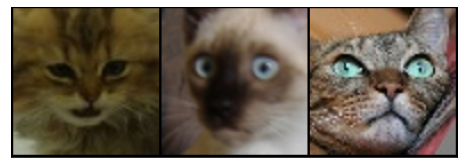

In [7]:
show_batch(train_dl)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)

In [14]:
#Дискриминатор
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 4, stride = 2, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 2, padding = 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 4, stride = 2, padding = 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 4, stride = 2, padding = 1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.conv6 = nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 4, stride = 2, padding = 1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.conv7 = nn.Conv2d(in_channels = 1024, out_channels = 1, kernel_size = 2, stride = 1)
        
        
        self.relu = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.conv7(x)
        x = self.flatten(x)
        x = self.Sigmoid(x)

        return x
        

In [33]:
discriminator = Regressor()
discriminator = to_device(discriminator, device)
latent_size = 128

In [16]:
#генератор
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.tr_conv1 = nn.ConvTranspose2d(in_channels = 128, out_channels = 1024, kernel_size = 4, stride = 1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.tr_conv2 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 4, stride = 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(512)
        self.tr_conv3 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 4, stride = 2, padding = 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.tr_conv4 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.tr_conv5 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 4, stride = 2, padding = 1)
        self.bn5 = nn.BatchNorm2d(64)
        self.tr_conv6 = nn.ConvTranspose2d(in_channels = 64, out_channels = 3, kernel_size = 4, stride = 2, padding = 1)
        
        
        
        self.relu = nn.ReLU()
        self.Tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.tr_conv1(x)))
        x = self.relu(self.bn2(self.tr_conv2(x)))
        x = self.relu(self.bn3(self.tr_conv3(x)))
        x = self.relu(self.bn4(self.tr_conv4(x)))
        x = self.relu(self.bn5(self.tr_conv5(x)))
        x = self.tr_conv6(x)
        x = self.Tanh(x)
        return x
        

In [32]:
generator = Generator()
generator = to_device(generator, device)

torch.Size([128, 3, 128, 128])


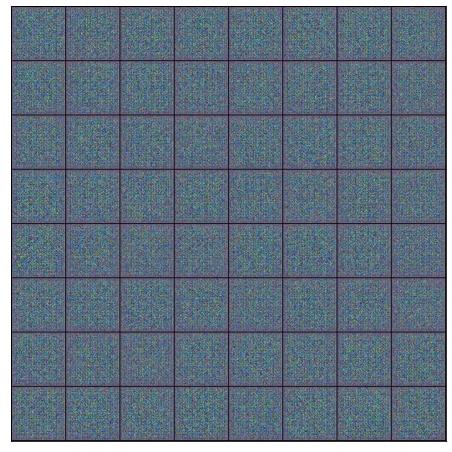

In [18]:
#посмотрим что выведет необученный генератор из произвольной точки из латентного пространства (это просто точка в 128 мерном пространстве (128 мы присвоили
# = latent_size))
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb.cuda())
print(fake_images.shape)
show_images(fake_images.cpu())

In [19]:
#это просто функция чтобы по окончании train'а выводилась сетка из 64 картинок
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [31]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [89]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 26

In [90]:
history = fit(model, criterion, epochs, lr)

100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [1/26], loss_g: 10.7676, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001


100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch [2/26], loss_g: 8.4096, loss_d: 0.5080, real_score: 0.9510, fake_score: 0.0786


100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [3/26], loss_g: 7.2061, loss_d: 0.3913, real_score: 0.9045, fake_score: 0.0981


100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch [4/26], loss_g: 6.4580, loss_d: 0.2539, real_score: 0.9189, fake_score: 0.0814


100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch [5/26], loss_g: 6.1716, loss_d: 0.3635, real_score: 0.9076, fake_score: 0.0855


100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [6/26], loss_g: 5.4553, loss_d: 0.4897, real_score: 0.8825, fake_score: 0.1104


100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [7/26], loss_g: 5.3174, loss_d: 0.2792, real_score: 0.9060, fake_score: 0.0939


100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch [8/26], loss_g: 4.9201, loss_d: 0.5332, real_score: 0.8853, fake_score: 0.0970


100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [9/26], loss_g: 4.8839, loss_d: 0.2130, real_score: 0.9363, fake_score: 0.0773


100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [10/26], loss_g: 4.0856, loss_d: 0.5686, real_score: 0.8787, fake_score: 0.1180


100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch [11/26], loss_g: 4.5602, loss_d: 0.3297, real_score: 0.9061, fake_score: 0.0918


100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [12/26], loss_g: 4.2319, loss_d: 0.4457, real_score: 0.8896, fake_score: 0.1010


100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch [13/26], loss_g: 5.1985, loss_d: 0.1074, real_score: 0.9734, fake_score: 0.0422


100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [14/26], loss_g: 5.6194, loss_d: 0.0193, real_score: 0.9940, fake_score: 0.0131


100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [15/26], loss_g: 7.3498, loss_d: 0.0125, real_score: 0.9948, fake_score: 0.0067


100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [16/26], loss_g: 9.0992, loss_d: 0.0074, real_score: 0.9978, fake_score: 0.0043


100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch [17/26], loss_g: 6.7613, loss_d: 0.3148, real_score: 0.9453, fake_score: 0.0459


100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch [18/26], loss_g: 6.2885, loss_d: 0.1697, real_score: 0.9593, fake_score: 0.0400


100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [19/26], loss_g: 5.7097, loss_d: 0.2581, real_score: 0.9345, fake_score: 0.0630


100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch [20/26], loss_g: 6.3680, loss_d: 0.0535, real_score: 0.9821, fake_score: 0.0246


100%|██████████| 79/79 [01:12<00:00,  1.10it/s]


Epoch [21/26], loss_g: 7.1964, loss_d: 0.0133, real_score: 0.9947, fake_score: 0.0074


100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch [22/26], loss_g: 7.4606, loss_d: 0.0112, real_score: 0.9960, fake_score: 0.0069


100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [23/26], loss_g: 8.1163, loss_d: 0.0072, real_score: 0.9973, fake_score: 0.0043


100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [24/26], loss_g: 5.6972, loss_d: 0.5772, real_score: 0.8721, fake_score: 0.0786


100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [25/26], loss_g: 5.7148, loss_d: 0.2256, real_score: 0.9354, fake_score: 0.0794


100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch [26/26], loss_g: 6.0830, loss_d: 0.3551, real_score: 0.9287, fake_score: 0.0658
Saving generated-images-0026.png


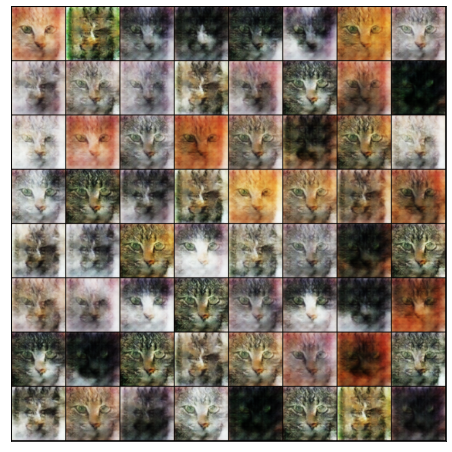

In [91]:
#Выведем сетку из 64 картинок на последней итерации обучения
losses_g, losses_d, real_scores, fake_scores = history
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

In [92]:
fixed_latent = torch.randn(1, latent_size, 1, 1, device=device)

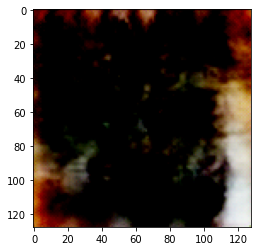

In [93]:
#так получаются темные картинки, лучше делать как ниже
fake_images = model["generator"](fixed_latent)
plt.imshow(fake_images.cpu().detach().squeeze().permute(1, 2, 0))

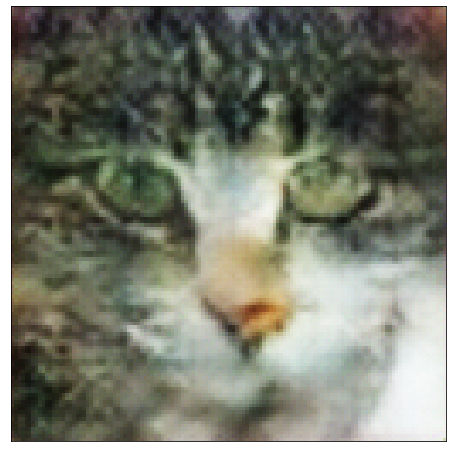

In [100]:
#Здесь все хорошо, можно менять второй параметр функции show_images чтобы показывать несколько картинок
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
fake_images = generator(fixed_latent.cuda())
show_images(fake_images.cpu(), 1)

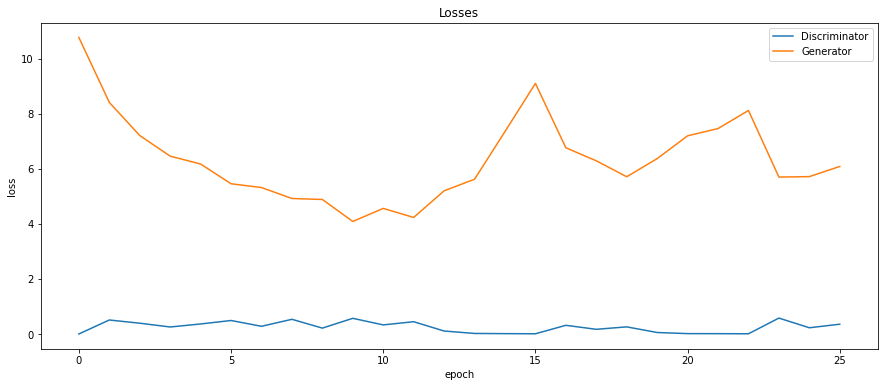

In [101]:
#график лосса
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

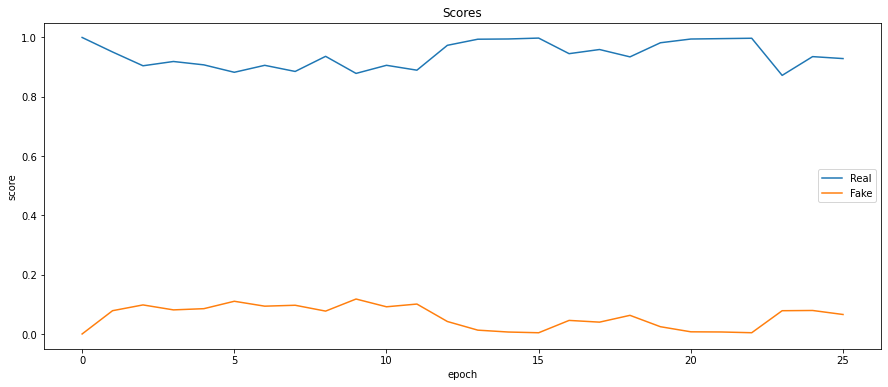

In [102]:
#график score'ов
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');